<div>
  <img style="float: left;"  width="140" src=" 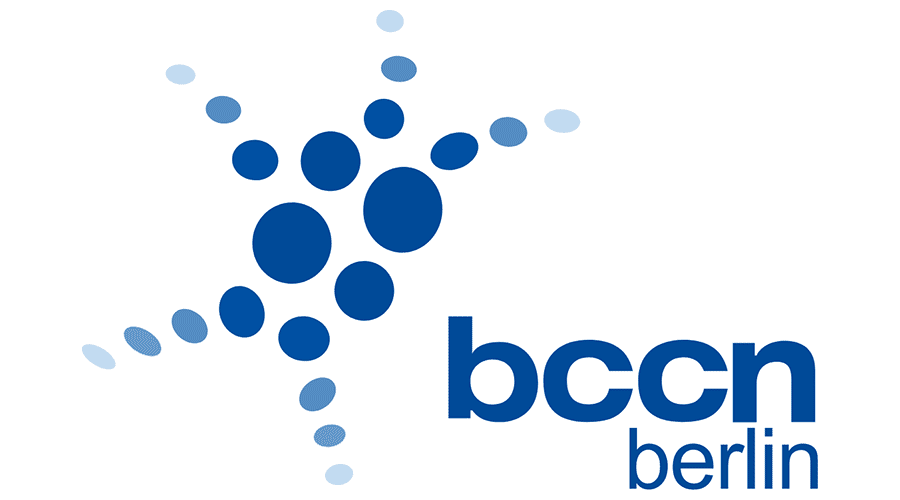">
</div>
 
<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Jarek Liesen
    <br>(jarek@bccn-berlin.de)
</div>



## General exercise instructions
These exercises should be completed entirely in this Jupyter Notebook (comprising source code, discussion and interpretation). Submission should be done through the Moodle interface and should consist only of this notebook (**a single `.ipynb` file**). This Jupyter Notebook was provided inside a `.zip` file, alongside additional files. Do not change the relative paths of these files when working on the assignment (meaning that e.g. `./helper.py` should always be in the same directory as this notebook).

Submission deadline is the start of the next lectue (**10:15 am on Fridays**).

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Some of the exercises will be automatically graded. Make sure that you:
1. Fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE"
2. Remove all `raise NotImplementedError` lines once you inserted your solution
3. Don't use variable names starting with underscore (e.g. `_myvar`) in your code, which could interfere with the automatic grading system.

Before you start, please fill in below your names and the name of your group as shown on Moodle. Example:
```
NAMES = ["Martina Musterfrau", "John Smith"]
GROUP = "A"
```

If you have any questions about the exercises, please ask them **on the Moodle forum** of the course.

In [3]:
NAMES = ["Liam Fogarty", "Ghadi El Hasbani"]
GROUP = "G"

In [4]:
# These are a few tests to make sure that your installed Python software is not too old
import sys
assert sys.version_info.major >= 3, "Your Python version is too old, please update it."

import IPython
assert IPython.version_info[0] >= 3, "Your IPython version is too old, please update it."

---

# Week 8: Reinforcement Learning II

In [5]:
# Necessary imports for this exercise, you can't modify these
import numpy as np
import matplotlib.pyplot as plt

# Import functions defined in the ./helpers.py file
from helpers import assert_var_defined, display_animation

# Import the GridWorld class
from gridworld import Gridworld

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: Good vs. bad Döner (7 points)

Consider a hungry reinforcement learning agent standing in a street with a bad and a good Döner shop, which are at different ends of the street. The goal of this exercise is to study the effects of the discount factor on the behavior of the agent.

### 1.1 Implemente a linear Döner-world (3 points)

Write a program that implements an agent in an environment of 50 linearly arranged states (corresponding to different positions along the street). In each state, the agent can choose among 2 actions: up or down, which take it to the respective neighboring states. In every trial, it starts in a random position. If the agent walks up in the top-most state, it receives a reward of 100 (bad Döner). If it walks down in the bottom-most state, it gets a reward of 1000 (good Döner). For every step that does not lead to a reward, the agent gets a negative reward of −10 (still no Döner). If either of the Döners is received, the trial ends and the agent starts a new trial at a new random position. Initialize the Q-values with small random numbers and let the agent learn according to the SARSA algorithm:

$$
\Delta Q(s_{t},a_{t}) = \eta (r_{t}+ \gamma Q(s_{t+1},a_{t+1}) - Q(s_{t},a_{t})) \, ,
$$

with $\eta$ = 0.1. The agent should follow an $\epsilon$-greedy policy with $\epsilon$ = 0.1. At the end of each trial, store the mean of all Q-values and the number of steps of the agent.

*Hint: Terminal states in this setting require special attention. To ensure that the TD-error can go to zero in the last iteration, you can introduce two additional states at the borders of the environment whose Q-values are always 0.*

In [73]:
class QAgent:
    def __init__(self, eta=0.1, epsilon=0.1, gamma=1.0, num_trials=10000, length=50):
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_trials = num_trials
        self.length = length
        self.q_means = np.zeros(num_trials)
        self.steps_taken = np.zeros(num_trials)
        self.q = np.random.normal(size=(self.length+2, 2))
        self.q[0, :] = 0
        self.q[-1, :] = 0

    def generate_reward(self, pos):
        if pos == 1:
            return 1000
        elif pos == self.length + 1:
            return 100
        else:
            return -10

    def update_q(self, state, action, reward, state2, action2):
        predict = self.q[state, action]
        target = reward + self.gamma * self.q[state2, action2]
        self.q[state, action] += self.eta * (target - predict)

    def update_state(self, state, action):
        if action == 1:
            return state + 1
        else:
            return state - 1

    def epsilon_greedy(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, 2)
        return np.argmax(self.q[state])

    def run_experiment(self):
        for trial in range(self.num_trials):
            t = 0
            start_pos = np.random.randint(low=1, high=51, size=1)[0]
            current_state = start_pos
            current_action = self.epsilon_greedy(current_state)
            
            while 0 < current_state < self.length + 1:
                reward = self.generate_reward(current_state)
                next_state = self.update_state(current_state, current_action)
                next_action = self.epsilon_greedy(next_state)
                self.update_q(current_state, current_action, reward, next_state, next_action)
                current_state = next_state
                current_action = next_action
                t += 1
            
            self.q_means[trial] = np.mean(self.q)
            self.steps_taken[trial] = t

        return self.q_means, self.steps_taken, self.q

### 1.2 Implement the agent

#### 1.2 a) Simulate the first agent (0.5 points)

Start with $\gamma$ = 1. Let the agent learn for 50,000 trials to make sure that the Q-values have converged. Then plot the following:
1. The duration of the trials as a function of trial number. This shows you if the agent is learning.
2. The mean of all Q-values as a function of trial number. This gives you an estimate of when the Q-values have converged.

Generate the same plot again but this time zoom in into the first 500 trials.

In [74]:
num_trials = 1000
agent = QAgent(gamma=1.0, num_trials=num_trials)
q_means, steps_taken, q_final = agent.run_experiment()
q_final

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+03,  2.21528242e+04],
       [ 1.95670546e+04,  1.87514999e+04],
       [ 1.91833432e+04,  1.83914844e+04],
       [ 1.88552704e+04,  1.77988573e+04],
       [ 1.80848195e+04,  1.76465109e+04],
       [ 1.79394626e+04,  1.68954741e+04],
       [ 1.78665153e+04,  1.41999994e+04],
       [ 1.69056766e+04,  1.14069762e+04],
       [ 1.66770409e+04,  1.20784769e+04],
       [ 1.63714373e+04,  1.05110441e+04],
       [ 1.61049630e+04,  8.53622121e+03],
       [ 1.45615088e+04,  7.92402552e+03],
       [ 1.53730157e+04,  8.12213030e+03],
       [ 1.52104200e+04,  6.73678986e+03],
       [ 1.47811076e+04,  4.74605828e+03],
       [ 1.34667409e+04,  3.53181156e+03],
       [ 1.28060114e+04,  1.93875665e+03],
       [ 1.16932673e+04,  2.75630452e+03],
       [ 1.01654780e+04,  2.08043415e+03],
       [ 9.03353017e+03,  8.55488824e+02],
       [ 7.50283213e+03,  4.45090797e+02],
       [ 6.49100913e+03,  6.26504817e+02],
       [ 4.

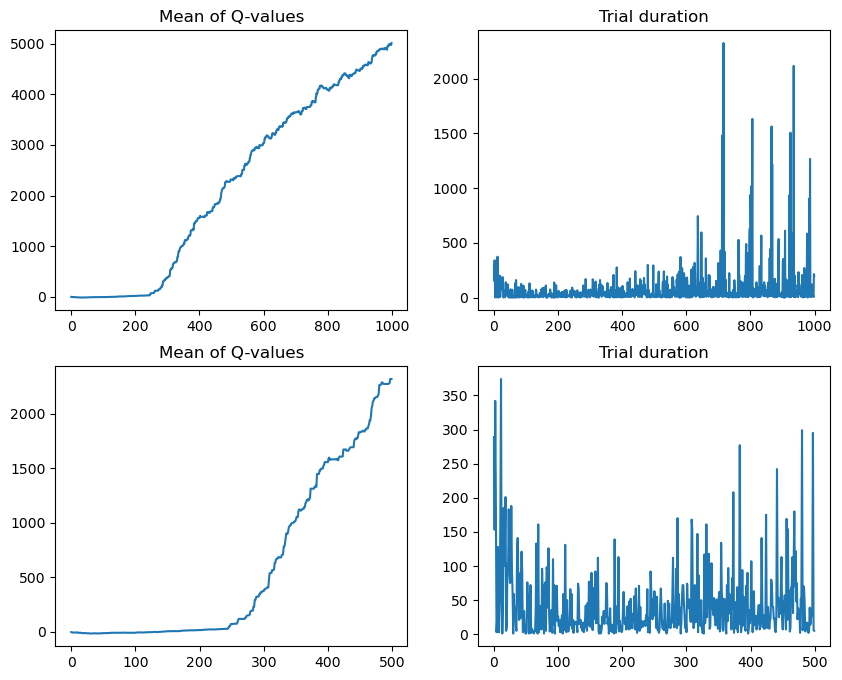

In [75]:

fig, ax = plt.subplots(2, 2, figsize = (10, 8))
ax[0,0].plot(range(num_trials), q_means)
ax[0,0].set_title('Mean of Q-values')
ax[0,1].plot(range(num_trials), steps_taken)
ax[0,1].set_title('Trial duration')

ax[1,0].plot(range(num_trials)[:500], q_means[:500])
ax[1,0].set_title('Mean of Q-values')
ax[1,1].plot(range(num_trials)[:500], steps_taken[:500])
ax[1,1].set_title('Trial duration')

plt.show()

#### 1.2 b) Explain your results (0.5 points)

You will observe that the agent’s behavior improves a lot faster than the Q-values converge - explain why! 

YOUR ANSWER HERE

#### 1.2 c) Plot the converged Q-values (1 point)

1. Plot two curves showing the final Q-values (after the 50.000 learning trials) over states - one curve for walking up and one for walking down.
2. In another figure, show the preferred action as a function of the state (up → 1, down → -1). 


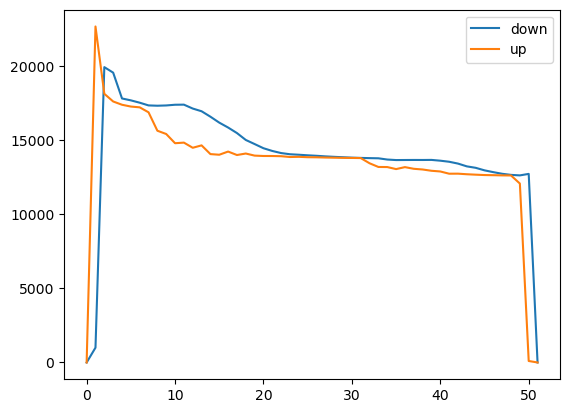

In [59]:
plt.plot(range(52), q_final[:, 0], label='down')
plt.plot(range(52), q_final[:, 1], label='up')
plt.legend()
plt.show()


#### 1.2 d) Explain your results (0.5 points)

How does the agent behave after learning and why?

YOUR ANSWER HERE

### 1.3 Repeat the simulation with different $\gamma$

#### 1.3 Run the simulations (0.5 points)
Plot the converged Q-values and preferred actions (as in exercise 1.2 c)) for discount factors $\gamma$ = 0.99, 0.95, 0.9, 0.8.


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### 1.3 b) Discuss your results (1 point)

How do the Q-values change? How does the final behavior of agent change? Provide an explanation.

YOUR ANSWER HERE

## Exercise 2: Gridworld (13 point)


In this exercise you will implement several methods in the class `Gridworld` (defined in `gridworld.py`) for reinforcement learning in 2-dimensions. Most of the class is already complete, but you must now apply your knowledge of 1-dimensional SARSA to a 2-dimensional problem.

### 2.0 Animating a trial of an agent

In the following, you will let your agents learn in gridworlds that you define. For visualiztion of the agent's behavior, you can use the `display_animation` function provided in `helpers.py`. This section will show you how an animation should look like once you have solved the exercises below.

Below is an example that should show you a running animation. Here, the `_run_trial` method of the `Gridworld` class was implemented such that the agent walks from the top left corner to the bottom left corner. After executing the cell below, you should see an animation in your Notebook. If this does not work for you, please contact your teaching assistant.

In [ ]:
def _run_from_top_left_to_bottom_left(self):
    """
    Run a single trial on the gridworld where the agent starts at the top left
    corner and walkds to the bottom left corner.
    """

    # Initialize the agent at the top left corner
    self.x_position = 4
    self.y_position = 0
    # visualize the first state in the animation
    self._visualize_current_state()

    # Now do 4 steps downwards
    for _ in range(4):
        # action = 1 means moving downwards (see Gridworld._update_state())
        self.action = 1
        # apply the action aka move the agent
        self._update_state()
        # visualize the new state in the animation
        self._visualize_current_state()

    # The _run_trial function needs to return the latency. Here the agent needs
    # 4 steps to reach the target.
    latency = 4
    return latency


# Overwrite the Gridworld._run_trial method with the function defined here
Gridworld._run_trial = _run_from_top_left_to_bottom_left


# Define a gridworld and display an animated trial
g_test = Gridworld(5)
g_test.run(N_trials=20)
anim = g_test.visualize_trial()
display_animation(anim)

### 2.1 Complete the `Gridworld` class (3 points)

Now that you know how these animations should look like, review the existing code that defines the `Gridworld` class (defined in `gridworld.py`) to get a sense of how the class functions. You can execute

```python
Gridworld?
```

in a notebook cell to have the class docstring and initializer docstring displayed (which is defined in `gridworld.py`). This gives you an overview of the class attributes and methods available to you.

Provide an implementation for the empty methods `_run_trial`, `_update_Q`, and `_choose_action`. To do that, complete the functions below. At the bottom of the cell, the class methods will be overwritten with your new definitions. Do not modify `gridworld.py` itself!

In [ ]:
Gridworld?

In [ ]:
def _run_trial(self):
    """
    Run a single trial on the gridworld until the agent reaches the reward position.
    Return the time it takes to get there.
    """
    # Initialize the latency (time to reach the target) for this trial
    latency = 0.0

    # Choose a random initial position and make sure that it is not in the wall.
    # Needed here:
    # self.x_position, self.y_position, self._is_wall()
    # YOUR CODE HERE
    raise NotImplementedError()

    # Run the trial by choosing an action and repeatedly applying SARSA
    # until the reward has been reached.
    # Needed here:
    # self._choose_action(), self._arrived(),  self._update_state(), self._update_Q()
    # YOUR CODE HERE
    raise NotImplementedError()

    return latency


def _update_Q(self):
    """
    Update the current estimate of the Q-values according to SARSA.
    """
    # update the eligibility trace
    # YOUR CODE HERE
    raise NotImplementedError()

    # update the Q-values:
    #
    #     deltaQ = eta * e * [reward - (Q_old - gamma * Q)]
    #
    # Needed here:
    # self.eta, self.e, self.gamma, self._reward,
    # self.action, self.x_position, self.y_position
    # self.action_old, self.x_position_old, self.y_position_old
    #
    # You need to make sure that your position and action variables are not `None` (which
    # they are initialized as).
    # YOUR CODE HERE
    raise NotImplementedError()


def _choose_action(self):
    """
    Choose the next action based on the current estimate of the Q-values.
    The parameter epsilon determines, how often agent chooses the action 
    with the highest Q-value (probability 1-epsilon). In the rest of the cases
    a random action is chosen.
    """
    # Be sure to store the old action before choosing a new one.
    # Needed here:
    # self.action, self.action_old, self.epsilon, self.Q, self.x_position, self.y_position
    # YOUR CODE HERE
    raise NotImplementedError()


# This overwrites the class methods with the functions you defined above
# Note: You are overwriting the methods in the class definition. Therefore, in each class
#       instance you create below - using gridworld.Gridworld(...) - these new functions
#       will be used
Gridworld._run_trial = _run_trial
Gridworld._update_Q = _update_Q
Gridworld._choose_action = _choose_action

### 2.2 Test your gridworld

The cell below creates a gridworld of size 5x5 and lets the agent learn for 20 trials. It then visualizes a new trial in an animation. This is only going to show an animation once you have implemented the methods in 2.1.


In [ ]:
# The animation will only show something once you have implemented the methods in 2.1.
g1 = Gridworld(5)
g1.run(N_trials=20)
anim = g1.visualize_trial()
display_animation(anim)

#### 2.2 a) Create a 10x10 gridworld (1 point)

Define a new `Gridworld` of size 10x10 and let the agent learn again for 20 trials.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### 2.2 b) Compare the two gridworlds (1 point)
What is the qualitative difference in the trials of the two gridworlds and how would you explain it?

YOUR ANSWER HERE

### 2.3 Compare the navigation maps and the Q maps

#### 2.3 a) Plot the navigation and Q maps (1 point)
Look at the navigation map of the agents, i.e., the action with the highest Q-value as a function of position using the class method `navigation_map()`. And also view the Q maps individually with class method `plot_Q()`. Do this for both gridworlds that you simulated above.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### 2.3 b) Explain the agent's behavior (1 point)

How is the behavior of the agent reflected in the navigation maps? Compare the structure of the maps close to the target position and at larger distances.

YOUR ANSWER HERE

### 2.4 Study the learning curves for both agents

#### 2.4 a) Plot the learning curves (0.5 points)

Quantify this difference by plotting the latencies (i.e., the time it takes the agent to reach the target position) as a function of trial number. This curve is often called the "learning curve". You can use the class method `learning_curve`. To get smoother curves, let the agent take 20 runs on the same problem and plot the latency curve averaged over all runs (rerun the `run` method and pass the number of runs as parameter `N_runs`). Do this for both gridworlds that you defined above.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### 2.4 b) Compare the learning curves (1.5 points)

1. Compare the latencies for the 2 gridworlds.
2. What are the latencies that you would expect if the agent has discovered the optimal strategy?
3. How do they compare to the latencies in the computer simulations?

YOUR ANSWER HERE

### 2.5) Study the effect of an eligibility trace

#### 2.5 a) Simulate an agent with eligibility trace (2 points)

Create 2 different gridworlds of size 20x20, one of which learns with an eligibility trace and the other one without. To enable the eligibility trace, set the constructor parameter `lambda_eligibility=0.9`.
Let the agents learn for 50-200 trials and 20 runs. Plot the Q maps and learning curves for both agents.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### 2.5 b) Compare the two agents (2 points)

- Why is the runtime of these simulations rather high?
- Compare the development of the latencies for the two agents. What do you observe and why?

YOUR ANSWER HERE